In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers tqdm matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
train_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/train'
test_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/test'

In [18]:
# define dataset transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
class DinoV2Model(nn.Module):
    def __init__(self, num_classes=10):
        super(DinoV2Model, self).__init__()
        self.vit = ViTModel.from_pretrained('facebook/dino-vits8')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x).last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(outputs)
        return logits

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DinoV2Model(num_classes=10)
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DinoV2Model(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_fe

Epoch 1/10: 100%|██████████| 32/32 [14:16<00:00, 26.78s/it]


Epoch 1, Train Loss: 1.3737, Train Accuracy: 62.10%
Validation Loss: 0.8065, Validation Accuracy: 72.00%


Epoch 2/10: 100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


Epoch 2, Train Loss: 0.3158, Train Accuracy: 89.20%
Validation Loss: 0.2975, Validation Accuracy: 93.00%


Epoch 3/10: 100%|██████████| 32/32 [00:53<00:00,  1.66s/it]


Epoch 3, Train Loss: 0.1340, Train Accuracy: 95.40%
Validation Loss: 0.1306, Validation Accuracy: 94.00%


Epoch 4/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 4, Train Loss: 0.0323, Train Accuracy: 99.00%
Validation Loss: 0.3750, Validation Accuracy: 97.00%


Epoch 5/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 5, Train Loss: 0.0249, Train Accuracy: 99.30%
Validation Loss: 0.1566, Validation Accuracy: 95.00%


Epoch 6/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 6, Train Loss: 0.0310, Train Accuracy: 99.20%
Validation Loss: 0.2508, Validation Accuracy: 94.00%


Epoch 7/10: 100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


Epoch 7, Train Loss: 0.0634, Train Accuracy: 97.70%
Validation Loss: 0.2230, Validation Accuracy: 92.00%


Epoch 8/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 8, Train Loss: 0.0467, Train Accuracy: 98.60%
Validation Loss: 0.1032, Validation Accuracy: 95.00%


Epoch 9/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 9, Train Loss: 0.1070, Train Accuracy: 96.70%
Validation Loss: 0.3385, Validation Accuracy: 90.00%


Epoch 10/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 10, Train Loss: 0.1968, Train Accuracy: 94.30%
Validation Loss: 0.3401, Validation Accuracy: 90.00%


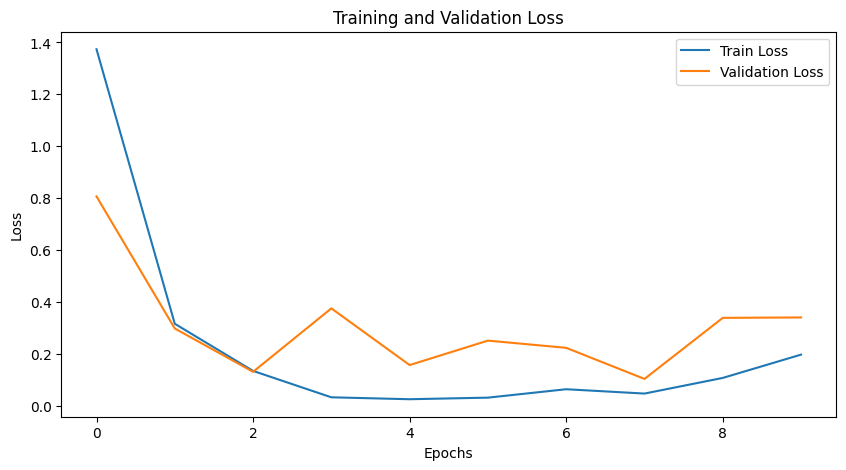

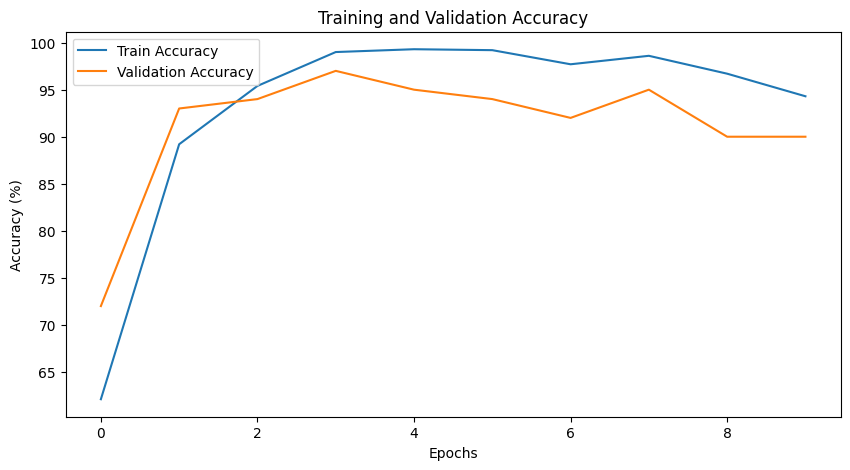

In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Variables to store metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Validation function
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    # Validation step
    val_loss, val_accuracy = validate(model, test_loader)

    # Store metrics for plotting
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Testing: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


Test Accuracy: 90.00%
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  1  0  0  0  8  0  0  1  0]
 [ 0  0  4  0  0  0  5  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  1  0  0  0  0  0  0  9  0]
 [ 0  1  0  0  0  0  0  0  0  9]]


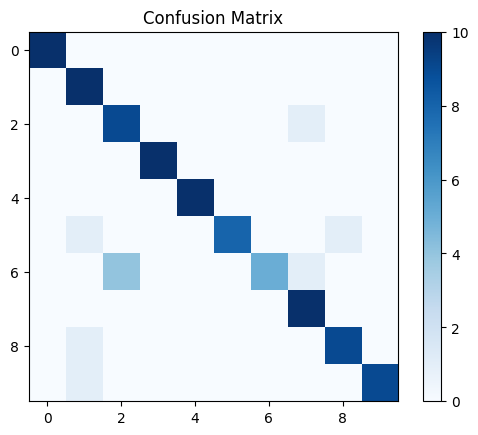

In [21]:
# Testing loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.show()